# Design Space Exploration Plugin

## Basics

The `Design` plugin (`tidy3d.plugins.design`) is a user-friendly tool that simplifies the process of defining and optimizing experiments within the `Tidy3D` environment. This plugin helps you efficiently explore different design possibilities by setting up a structured approach to test and refine your ideas.

To get started, define the key `Parameters` of your design problem and choose a `Method` that will suggest possible solutions. The ``Method`` can sample the design space systematically or randomly using `MethodGrid` or `MethodMonteCarlo`, or can optimize for a given problem through iterative search and evaluation using techniques like Bayesian optimization (`MethodBayOpt`), genetic algorithm (`MethodGenAlg`) or particle swarm optimization (`MethodParticleSwarm`). These choices are combined into a `DesignSpace` object, which serves to manage the search process.

Next, provide a function that describes the relationship between your input variables (the dimensions of your design) and the desired outputs. This function can take any inputs and return any outputs that you want to investigate.

The results of the search are automatically stored in a `Result` object. This object contains all the details of the search and can be quickly converted into a `pandas.DataFrame` for further analysis, post-processing, or visualization. In this `DataFrame`, each column represents an input or output from your function, and each row represents a single data point from your experiment.

Here’s a diagram to details the process step-by-step.

<img src="img/design.png" alt="sweep" width="800"/>

Another example of the `Design` plugin can be seen about halfway down our [Parameter Scan](https://www.flexcompute.com/tidy3d/examples/notebooks/ParameterScan) notebook. A simple practical case study of the `Design` plugin is available in the [All-Dielectric Structural Color ](https://www.flexcompute.com/tidy3d/examples/notebooks/AllDielectricStructuralColor/) notebook, or more complex case studies in the following optimization notebooks:

1. [Bayesian Optimization of Y-Junction](https://www.flexcompute.com/tidy3d/examples/notebooks/BayesianOptimizationYJunction/)

2. [Particle Swarm Optimizer PBS](https://www.flexcompute.com/tidy3d/examples/notebooks/ParticleSwarmOptimizedPBS/)

3. [Particle Swarm Optimizer Bullseye Cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/)

4. [Genetic Algorithm Reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GeneticAlgorithmReflector/)


The plugin is imported from `tidy3d.plugins.design` so it's convenient to import this namespace first along with the other packages we need.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import typing

import tidy3d as td
import tidy3d.plugins.design as tdd

## Quickstart

While the `Design` plugin is built for `Tidy3D` and has special features for handling FDTD simulations, it can also be run with any general design problem. Here is a quick, complete example before diving into the use of the plugin with `Tidy3D` simulations.

Here we want to sample a design space with two dimensions `x` and `y` with Monte Carlo. Our function simply returns a Gaussian centered at `(0,0)` and we'll evaluate the result for Gaussians with 3 different variances.

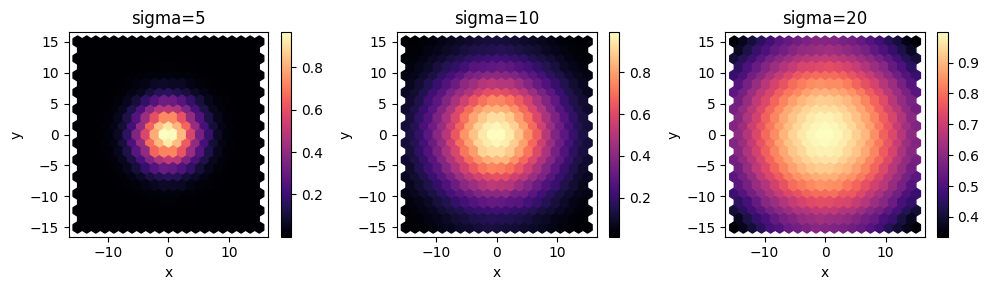

In [3]:
# Define your design space (parameters (x,y) within certain ranges)
param_x = tdd.ParameterFloat(name="x", span=(-15,15))
param_y = tdd.ParameterFloat(name="y", span=(-15,15))

# Define your sampling method, Monte Carlo method with 10,000 points
method = tdd.MethodMonteCarlo(num_points=10000)

# Put everything together in a `DesignSpace` container
design_space = tdd.DesignSpace(method=method, parameters=[param_x, param_y])

# Define your fitness function / figure of merit. Here we compute a gaussian as a function of x and y with different values for the width.
sigmas = {f"sigma={s}": s for s in [5, 10, 20]}
def f(x:float, y:float) -> typing.Dict[str, float]:
    """gaussian distribution as a function of x and y."""
    r2 = x**2 + y**2
    gaussian = lambda sigma: np.exp(-r2 / sigma ** 2)
    # return a dictionary, where the key is used to label the output names
    return {key: gaussian(sigma) for key, sigma in sigmas.items()}

# Call .run on the DesignSpace with our function and convert the results to a pandas.DataFrame
df = design_space.run(f).to_dataframe()

# Plot the results using pandas.DataFrame builtins
f, axes = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
for ax, C in zip(axes, sigmas.keys()):
    _ = df.plot.hexbin(x='x', y='y', gridsize=20, C=C, cmap="magma", ax=ax)
    ax.set_title(C)


In [4]:
# Look at the first 5 outputs
df.head()

,x,y,sigma=5,sigma=10,sigma=20
0,-9.287730,-3.498281,1.944830e-02,0.373440,0.781727
1,7.280786,-1.283115,1.123373e-01,0.578937,0.872284
2,-14.875910,-11.875533,5.079723e-07,0.026697,0.404217
3,6.986373,-4.965107,5.294678e-02,0.479689,0.832223
4,4.749807,6.478849,7.566453e-02,0.524473,0.851002


##  Design Space Exploration in Tidy3D

We can repeat the same process to perform a parameter sweep of a photonic device. The only difference is that for our function evaluation each point will involve a `Tidy3D` `Simulation`.

Let's analyze the transmission of a 1D multilayer slab. Our system will have `num` layers with refractive index alternating between two values, each with thickness `t`. We write a function to compute the transmitted flux through this system at frequency `freq0` as a function of `num` and `t`.

In [5]:
lambda0 = 0.63
freq0 = td.C_0 / lambda0

mnt_name = "flux"
buffer = 1.5 * lambda0

refractive_indices = [1.5, 1.2]

We split our simulation process into pre- and post-processing functions so that the `Design` plugin can handle creating one large `Batch`, to be run in parallel on the `Tidy3D` cloud. The pre-processing function returns a `tidy3d.Simulation` as a function of the input parameters and the post-processing function returns the transmitted flux as a function of the `tidy3d.SimulationData` associated with the simulation.

In [6]:
def pre(num: int, t: float) -> td.Simulation:
    """Pre-processing function, which creates a tidy3d simulation given the function inputs."""
    layers = []
    z = 0
    for i in range(num):
        n = refractive_indices[i % len(refractive_indices)]
        thickness = t * lambda0 / n
        medium = td.Medium(permittivity = n ** 2)
        geometry = td.Box(center=(0, 0, z + thickness / 2), size=(td.inf, td.inf, thickness))
        layers.append(td.Structure(geometry=geometry, medium=medium))
        z += thickness
    Lz = z + 2 * buffer
    sim = td.Simulation(
        size=(0, 0, Lz),
        center=(0, 0, z / 2),
        structures=layers,
        sources=[td.PlaneWave(
            size=(td.inf, td.inf, 0),
            center=(0, 0, -buffer * 0.75),
            source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0/10),
            direction="+",
        )],
        monitors=[td.FluxMonitor(
            size=(td.inf, td.inf, 0),
            center=(0, 0, z + buffer * 0.75),
            freqs=[freq0],
            name=mnt_name,
        )],
        boundary_spec=td.BoundarySpec.pml(x=False, y=False, z=True),
        run_time=100 / freq0,
    )
    return sim

def post(data: td.SimulationData) -> dict:
    """Post-processing function, which processes the tidy3d simulation data to return the function output."""
    flux = np.sum(data['flux'].flux.values)
    return {"flux": flux}


When using `MethodMonteCarlo` or `MethodGrid` we can choose to have our post-processing function return a dictionary `{"flux": flux}` instead of just a `float`. If a dictionary is returned, the `Design` plugin will use the keys to label the dataset outputs. 

For the optimization tools (`MethodBayOpt`, `MethodGenAlg`, `MethodParticleSwarm`) we must return a float that the optimization can use to evaluate the solution and progress. However, we can return values named as auxiliary data using a notation like `[float, dict{"aux1": x}]`.


> Note: if we were to write the full transmission function using pre and post it would look like the function below. However, the `Design` plugin will handle running the simulation for us, as we'll see later.

```python
def transmission(num: int, t: float) -> float:
    """Transmission as a function of number of layers and their thicknesses.
         Note: not used, just a demonstration of how the pre and post functions are related.
    """
    sim = pre(num=num, t=t)
    data = web.run(sim, task_name=f"num={num}_t={t}")
    return post(data=data)
```


Let's visualize the simulation for some example parameters to make sure it looks ok.

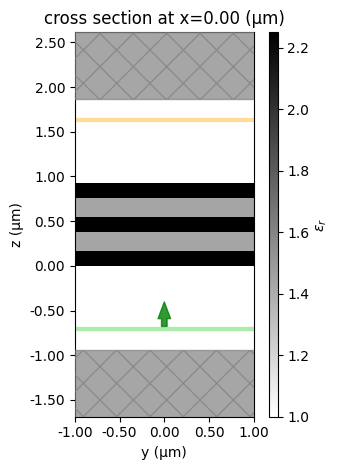

In [7]:
sim = pre(num=5, t=0.4)
ax = sim.plot_eps(x=0, hlim=(-1, 1))


##  Parameters

We could query these functions directly to perform our own parameter scan, but the advantage of the `Design` plugin is that it lets us simply **define** our design problem as a specification and then takes manages the computation for us.

The first step is to define the design "parameters" (or dimensions), which also serve as inputs to our `pre` function defined earlier.

In this case, we have a parameter `num`, which is a non-negative integer and a parameter `t`, which is a positive float.

We can construct a named `tdd.Parameter` for each of these and define some spans as well. The `name` fields should correspond to the argument names defined in the `pre` function.

In [8]:
param_num = tdd.ParameterInt(name='num', span=(1, 5))
param_t = tdd.ParameterFloat(name='t', span=(0.1, 0.5), num_points=5)

The float parameter takes an optional `num_points` option, which tells the design tool how to discretize the continuous dimension only when doing a grid sweep with `MethodGrid`: for Monte Carlo sweeps, it is not used.

It is also possible to define parameters that are simply sets of quantities that we might want to select using `allowed_values`, such as:

In [9]:
param_str = tdd.ParameterAny(name="some_string", allowed_values=("these", "are", "values"))

but we will ignore this case as it's not needed here and the internal logic is similar to that for integer parameters.

> Note: to do more complex sets of integer parameters (like skipping every 'n' integers). We recommend simply using `ParameterAny` and just passing your integers to `allowed_values`.

By defining our design parameters like this, we can more concretely define what types and allowed values can be passed to each argument in our function for the parameter sweep.

##  Method

Now that we've defined our parameters, we also need to define the procedure used to sample the parameter space we've defined. As mentioned above, one approach is to independently sample points within the parameter spans, for example using a Monte Carlo method, another is to perform a grid search to uniformly scan between the bounds of each dimension. There are also more complex methods, such as [Bayesian optimization]() and [genetic algorithms](https://www.flexcompute.com/tidy3d/examples/notebooks/GeneticAlgorithmReflector/), which can be seen in these other notebooks.

In the `Design` plugin, we define the specifications for the parameter sweeps using `Method` objects.

Here's one example, which defines a grid search.

In [10]:
method = tdd.MethodGrid()

For this example, let's instead do a Monte Carlo sampling with a set number of points.

In [11]:
method = tdd.MethodMonteCarlo(num_points=40)

## Design Space

With the design parameters and our method defined, we can combine everything into a `DesignSpace`, which is mainly a container that provides some higher level methods for interacting with these objects.

In [21]:
design_space = tdd.DesignSpace(parameters=[param_num, param_t], method=method, path_dir="./data", folder_name="Design_Tutorial", task_name="Design_notebook")

We can provide a `path_dir` to specify the local directory location where files should be stored, and the `folder_name` which is the location on `Tidy3D` cloud where the `Simulations` will be kept.

The `task_name` argument asigns the root of task name for `Tidy3D` cloud. This is combined with the index of the `Simulation` output by the `Pre` function (often 0) and a counter for the simulations run by the `DesignSpace` in this format: 

`{task_name}_{sim_index}_{counter}` 

If the `Pre` function outputs `Simulation` objects as a dictionary then the keys from the dictionary replace the `sim_index` to be: 

`{task_name}_{dict_key}_{counter}`

### Working with Pre and Post functions

Now we need to pass our `Pre` and `Post` functions to the `DesignSpace` object to get our results.

To start the parameter scan the `DesignSpace` uses the method `.run()`, which accepts our function(s) defined earlier. If a single function is supplied to the `DesignSpace` it will be called exactly as the user specified. If pre and post functions are supplied to the `DesignSpace` then the `Simulation` objects will be efficiently assembled into `Batch` objects to be run in parallel on the `Tidy3D` cloud. The return from the `Pre` function can be in many different forms, with the table below outlining some example `Pre` return formats and the associated format that the `Post` function should be able to receive.

<center>

| fn_pre return                             | fn_post call                                      |
|-------------------------------------------|---------------------------------------------------|
| 1.0                                       | fn_post(1.0)                                      |
| [1,2,3]                                   | fn_post(1,2,3)                                    |
| {'a': 2, 'b': 'hi'}                       | fn_post(a=2, b='hi')                              |
| Simulation                                | fn_post(SimulationData)                           |
| Batch                                     | fn_post(BatchData)                                |
| [Simulation, Simulation]                  | fn_post(SimulationData, SimulationData)           |
| [Simulation, 1.0]                         | fn_post(SimulationData, 1.0)                      |
| [Simulation, Batch]                       | fn_post(SimulationData, BatchData)                |
| {'a': Simulation, 'b': Batch, 'c': 2.0}   | fn_post(a=SimulationData, b=BatchData, c=2.0)     |

</center>

As you can see, it is possible to output `Batch` objects for the `DesignSpace` to compute. These batches are run sequentially, so it is often faster for the `Pre` function to output a container of `Simulation` objects which are then combined by the `DesignSpace` into a `Batch` for parallel computation. A `Batch` can be used if the user has specific needs when running on the `Tidy3D` cloud.

## Results

The `DesignSpace.run()` function returns a `Result` object, which is basically a dataset containing the function inputs, outputs, source code, and any task ID information corresponding to each data point.

> Note that task ID information can only be gathered when using pre and post functions, as in a single function the `DesignSpace` can't know which tasks were involved in each data point.

In [22]:
results = design_space.run(pre, post)

08:56:24 BST Running 40 Simulations

08:56:25 BST ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

             ERROR: The name already exists.                                    

We can pass `verbose=False` to the function if we don't want to see the outputs for large design searches. The "name already exists" error can be ignored here.


`Results` contains three main related datastructures.

* `dims`, which correpsond to the `kwargs` of the pre-processing function, `('num', 't')` here.

* `coords`, which is a tuple containing the values passed in for each of the dims. `coords[i]` is a tuple of `n`, and `t` values for the `i`th function call.

* `values`, which is a tuple containing the outputs of the postprocessing functions. In this case `values[i]` stores the transmission of the `i`th function call.

The `Results` can be converted to a `pandas.DataFrame` where each row is a separate data point and each column is either an input or output for a function. It also contains various methods for plotting and managing the data.

In [14]:
# The first 5 data points
df = results.to_dataframe()
df.head()

,num,t,flux
0,3,0.231423,0.712001
1,3,0.327886,0.952495
2,3,0.306500,0.862998
3,4,0.366405,0.998939
4,1,0.128428,0.913065


The `pandas` [documentation](https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html#min-tut-01-tableoriented) provides excellent explanations of the various postprocessing and visualization functions that can be used.

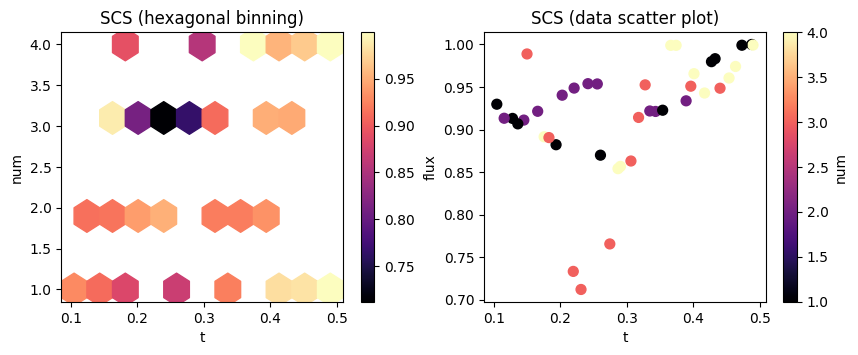

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

# plot a hexagonal binning of the results
im = df.plot.hexbin(x="t", y="num", gridsize=10, C="flux", cmap="magma", ax=ax1)
ax1.set_title('SCS (hexagonal binning)')

# scatterplot the raw results with flux on the y axis
im = df.plot.scatter(x="t", y="flux", s=50, c="num", cmap="magma", ax=ax2)
ax2.set_title('SCS (data scatter plot)')

plt.show()

> These functions just call `pandas.DataFrame` plotting under the hood, so it is worth referring to the [docs page on DataFrame visuazation](https://pandas.pydata.org/docs/user_guide/visualization.html) for more tips on plotting design problem results.

### Modifying Results

After the design problems is run, one might want to modify the results through adding or removing elements or combining different results. Here we will show how to perform some of these advanced features in the `Design` plugin.

#### Combining Results

We can combine the results of two separate design problems assuming they were created with the same functions.

This can be done either with `result.combine(other_result)` or with a shorthand of `result + other_result`.

In this example, let's say we want to explore more the region where the transmission seems to be lowest, for `t` between 0.2 and 0.3. We create a new parameter with the desired span for `t` and use it to create an updated copy of the previous design, still using the same method.

In [16]:
param_t2 = tdd.ParameterFloat(name='t', span=(0.2, 0.3), num_points=5)
design_space2 = design_space.updated_copy(parameters=[param_num, param_t2])
results2 = design_space2.run(pre, post)

08:34:22 BST Running 40 Simulations

Now we can inspect the new results and the combined data as we did before:

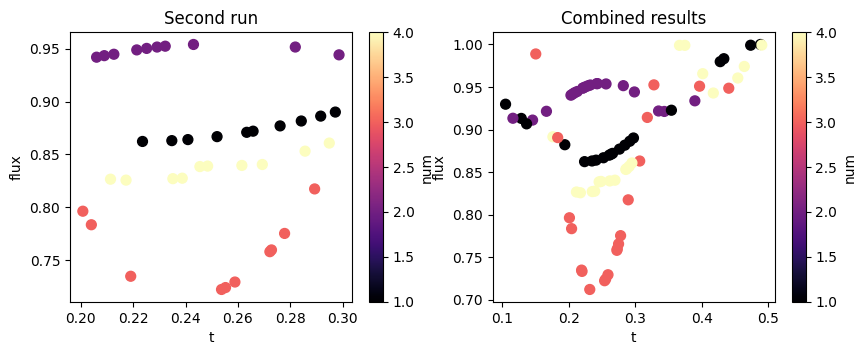

In [17]:
results_combined = results + results2

df2 = results2.to_dataframe()
df_combined = results_combined.to_dataframe()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

im = df2.plot.scatter(x="t", y="flux", s=50, c="num", cmap="magma", ax=ax1)
ax1.set_title('Second run')

im = df_combined.plot.scatter(x="t", y="flux", s=50, c="num", cmap="magma", ax=ax2)
ax2.set_title('Combined results')

plt.show()

#### Adding and removing results

We can also add and remove individual entries from the `Results` with the `add` and `delete` methods.

Let's add a new data point to our results and then delete it.

In [25]:
# define the function inputs and outputs
fn_args = {"t": 1.2, "num": 5}
value = 1.9

To add a data element, we pass in the `fn_args` (inputs) and the `value` (outputs).

In [26]:
# add it to the results and view the last 5 entries (data is present)
results = results.add(fn_args=fn_args, value=value)
results.to_dataframe().tail()

,num,t,flux
36,3,0.477944,0.995562
37,2,0.383136,0.929275
38,2,0.267950,0.950784
39,3,0.277211,0.773291
40,5,1.200000,1.900000


We can select a specific data point by passing the function inputs as keyword arguments to the `Results.sel` method.

In [27]:
print(results.sel(**fn_args))

1.9


Similarly, we can remove a data point by passing the `fn_args` (inputs) to the `Results.delete` method.

In [28]:
# remove this data from the results and view the last 5 entries (data is gone)
results = results.delete(fn_args=fn_args)
results.to_dataframe().tail()

,num,t,flux
35,1,0.362959,0.930869
36,3,0.477944,0.995562
37,2,0.383136,0.929275
38,2,0.267950,0.950784
39,3,0.277211,0.773291


#### Leveraging DataFrame functions

Since we have the ability to convert the `Results` to and from `pandas.DataFrame` objects, we are able to perform various manipulations (including the ones above) on the data using `pandas`. For example, we can create a new `DataFrame` object that multiplies all of the original `flux` values by 1/2 and convert this back to a  `Result` if desired.

In [29]:
df = results.to_dataframe()
df.head()

,num,t,flux
0,4,0.151689,0.946493
1,4,0.427012,0.937147
2,2,0.244466,0.954050
3,2,0.326142,0.923577
4,1,0.484898,0.999998


In [30]:
# get a dataframe where everything is squared
df_half_flux = df.copy()
df_half_flux["flux"] = df_half_flux["flux"].map(lambda x: x * 0.5)
df_half_flux.head()

,num,t,flux
0,4,0.151689,0.473247
1,4,0.427012,0.468574
2,2,0.244466,0.477025
3,2,0.326142,0.461788
4,1,0.484898,0.499999


We generally recommend you make use of the many features provided by `pandas.DataFrame` to do further postprocessing and analysis of your sweep results, but to convert a `DataFrame` back to a `Result`, one can simply pass it to `Results.from_dataframe` along with the dimensions of the data (if the `DataFrame` has been modified).

In [25]:
# Load it into a Result, note that we need to pass dims because this is an entirely new DataFrame without metadata
results_squared = tdd.Result.from_dataframe(df_half_flux, dims=("num", "t"))

## Accessing Batched Data

It is possible to load the `SimulationData` objects from the `.hdf5` files that will have been downloaded locally during the `DesignSpace.run` operation. When using `Pre` and `Post` functions the `Results` object stores the `task_names` and `task_paths` to make it easy to identify and load the correct file for further analysis.

In [24]:
# See the first three file paths
print(results.task_paths[:3])

# Load the SimulationData back into Python
loaded_sim_data = td.SimulationData.from_file(results.task_paths[0])

['./data/fdve-ba077ef4-b5e0-47ad-bb00-7d991abb089e.hdf5', './data/fdve-e9887d59-1261-433a-a878-f6498c1c3ac4.hdf5', './data/fdve-358eb0f9-f1b9-4362-83a5-16489b5dd7e8.hdf5']


The `task_names` and `task_paths` and stored in the same structure as the return from the `Pre` function to aid with accessing the appropriate `SimulationData` for a particular output value. For example, if the `Pre` function returns a list like `[Simulation, Simulation, Simulation]`, then the `task_paths` will be stored as a list of corresponding paths: `[path, path, path]`. 

## Working with Optimizers

Using a grid search or Monte Carlo are good ways to sample a large design space. However, the `Design` plugin can go further and enable efficient optimization of a design problem using a range of different optimization techniques. `Method` objects such as Bayesian optimization, genetic algorithms, and partical swarm optimization can all be used in the same way as the above examples. These methods use a `float` value output by the post function to evaluate the effectiveness of a solution, and then propose new solutions that should prove better. More detailed examples can be found in the notebooks associated with each technique.

1. [Bayesian Optimization of Y-Junction](https://www.flexcompute.com/tidy3d/examples/notebooks/BayesianOptimizationYJunction/)

2. [Particle Swarm Optimizer PBS](https://www.flexcompute.com/tidy3d/examples/notebooks/ParticleSwarmOptimizedPBS/)

3. [Particle Swarm Optimizer Bullseye Cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/)

4. [Genetic Algorithm Reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GeneticAlgorithmReflector/)


There are a few additional points to consider when using optimizers:
* Optimizers are more complicated to use than samplers and have many different options to consider in the `Method` object. It is worth reading the `Tidy3D` docs and relevant package documentation for each optimizer before use.
* Optimizers require the output of `fn_post` to be either a `float` or `[float, list/tuple/dict]`. The additional information in the container will be handled as auxiliary data and stored in the `Results`. It can be added to the `pd.DataFrame` with `results.to_dataframe(include_aux=True)`.
* Optimizers work best when the design problem is split into pre and post functions as the `DesignSpace` can create efficient batches of `Simulation` objects, instead of running the entire optimization process sequentially, which can take a long time.